
# 🎨 Advanced Data Visualization

**Project:** Real-Time Air Quality Index Predictor

**Phase:** 2 - Exploratory Data Analysis

**Notebook:** 02 - Advanced Visualization & Geographic Analysis

**Objective:** Create interactive, publication-quality visualizations to understand spatial and temporal patterns.

---

## 📋 Contents
1. Setup & Data Loading
2. Geographic Visualization (Interactive Map!)
3. Time Series Deep Dive
4. Correlation Analysis
5. Interactive Dashboards
6. Pollutant Relationships
7. Export & Save

## 1. Setup & Data Loading

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

# Data & analysis
import pandas as pd
import numpy as np
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins

# Project modules
from src.data.cleaners import DataCleaner
from src.utils.config import get_config

# Configure
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
%matplotlib inline

print("✅ Libraries loaded!")

2025-10-29 10:51:31 | INFO     | src.utils.logger:setup:103 | Logging system initialized
2025-10-29 10:51:31 | INFO     | src.utils.logger:setup:104 | Log level: INFO
2025-10-29 10:51:31 | INFO     | src.utils.logger:setup:106 | Log directory: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/data/logs
✅ Libraries loaded!


In [2]:
# Load data
cleaner = DataCleaner()
df = cleaner.clean_data(cleaner.load_all_raw_data())
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load city configurations
config = get_config()
cities_config = config.get_cities()

print(f"✅ Loaded {len(df)} records")
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"🌍 Cities: {', '.join(df['city_name'].unique())}")

2025-10-29 10:51:40 | INFO     | src.data.cleaners:__init__:62 | DataCleaner initialized
2025-10-29 10:51:40 | INFO     | src.data.cleaners:load_all_raw_data:108 | Found 39 raw data files
2025-10-29 10:51:40 | INFO     | src.data.cleaners:load_all_raw_data:135 | Removed 18 duplicate records
2025-10-29 10:51:40 | INFO     | src.data.cleaners:load_all_raw_data:137 | Combined dataset: 216 records
2025-10-29 10:51:40 | INFO     | src.data.cleaners:clean_data:367 | Starting data cleaning pipeline
2025-10-29 10:51:40 | INFO     | src.data.cleaners:clean_data:368 | Input: 216 records, 14 columns
2025-10-29 10:51:40 | INFO     | src.data.cleaners:validate_schema:167 | Schema validation passed
2025-10-29 10:51:40 | INFO     | src.data.cleaners:validate_data_ranges:185 | Validating data ranges
2025-10-29 10:51:40 | INFO     | src.data.cleaners:handle_missing_values:232 | Handling missing values
2025-10-29 10:51:40 | INFO     | src.data.cleaners:detect_outliers:281 | Detecting outliers using iqr 

/Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/src/data/cleaners.py:250: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[city_mask, pollutant_cols] = df.loc[city_mask, pollutant_cols].fillna(method='ffill', limit=3)
/Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/src/data/cleaners.py:250: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[city_mask, pollutant_cols] = df.loc[city_mask, pollutant_cols].fillna(method='ffill', limit=3)
/Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/src/data/cleaners.py:250: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[city_mask, p

## 2. Geographic Visualization - Interactive World Map 🗺️

In [3]:
# Create interactive world map
print("🗺️  Creating interactive world map...")

# Calculate average AQI per city
city_summary = df.groupby('city_key').agg({
    'city_name': 'first',
    'country': 'first',
    'aqi': 'mean',
    'pm2_5': 'mean',
    'pm10': 'mean'
}).reset_index()

# Add coordinates
city_summary['latitude'] = city_summary['city_key'].map(
    lambda x: cities_config[x]['latitude']
)
city_summary['longitude'] = city_summary['city_key'].map(
    lambda x: cities_config[x]['longitude']
)

# Create map centered on world
world_map = folium.Map(
    location=[20, 0],
    zoom_start=2,
    tiles='OpenStreetMap'
)

# Add markers for each city
for _, city in city_summary.iterrows():
    # Color based on AQI
    if city['aqi'] <= 2:
        color = 'green'
        icon = 'leaf'
        status = 'Good/Fair'
    elif city['aqi'] == 3:
        color = 'orange'
        icon = 'exclamation-triangle'
        status = 'Moderate'
    else:
        color = 'red'
        icon = 'warning'
        status = 'Poor/Very Poor'
    
    # Create popup with city info
    popup_html = f"""
    <div style="font-family: Arial; font-size: 12px; width: 200px;">
        <h4 style="margin: 0 0 10px 0; color: {color};">{city['city_name']}, {city['country']}</h4>
        <b>Status:</b> {status}<br>
        <b>Average AQI:</b> {city['aqi']:.2f}<br>
        <b>PM2.5:</b> {city['pm2_5']:.2f} μg/m³<br>
        <b>PM10:</b> {city['pm10']:.2f} μg/m³<br>
    </div>
    """
    
    folium.Marker(
        location=[city['latitude'], city['longitude']],
        popup=folium.Popup(popup_html, max_width=250),
        tooltip=f"{city['city_name']}: AQI {city['aqi']:.1f}",
        icon=folium.Icon(color=color, icon=icon, prefix='fa')
    ).add_to(world_map)
    
    # Add circle to show pollution intensity
    folium.Circle(
        location=[city['latitude'], city['longitude']],
        radius=city['aqi'] * 100000,  # Scale by AQI
        color=color,
        fill=True,
        opacity=0.3,
        fillOpacity=0.2
    ).add_to(world_map)

# Save map
map_path = project_root / 'notebooks' / 'city_aqi_map.html'
world_map.save(str(map_path))

print(f"✅ Interactive map saved to: {map_path}")
print("📍 The map will display below AND you can open the HTML file in your browser!")
print("\n🎨 Legend:")
print("   🟢 Green = Good/Fair air quality")
print("   🟠 Orange = Moderate air quality")
print("   🔴 Red = Poor/Very Poor air quality")
print("   Circle size = Pollution intensity")

# Display in notebook
world_map

🗺️  Creating interactive world map...
✅ Interactive map saved to: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/notebooks/city_aqi_map.html
📍 The map will display below AND you can open the HTML file in your browser!

🎨 Legend:
   🟢 Green = Good/Fair air quality
   🟠 Orange = Moderate air quality
   🔴 Red = Poor/Very Poor air quality
   Circle size = Pollution intensity


## 3. Time Series Deep Dive 📈

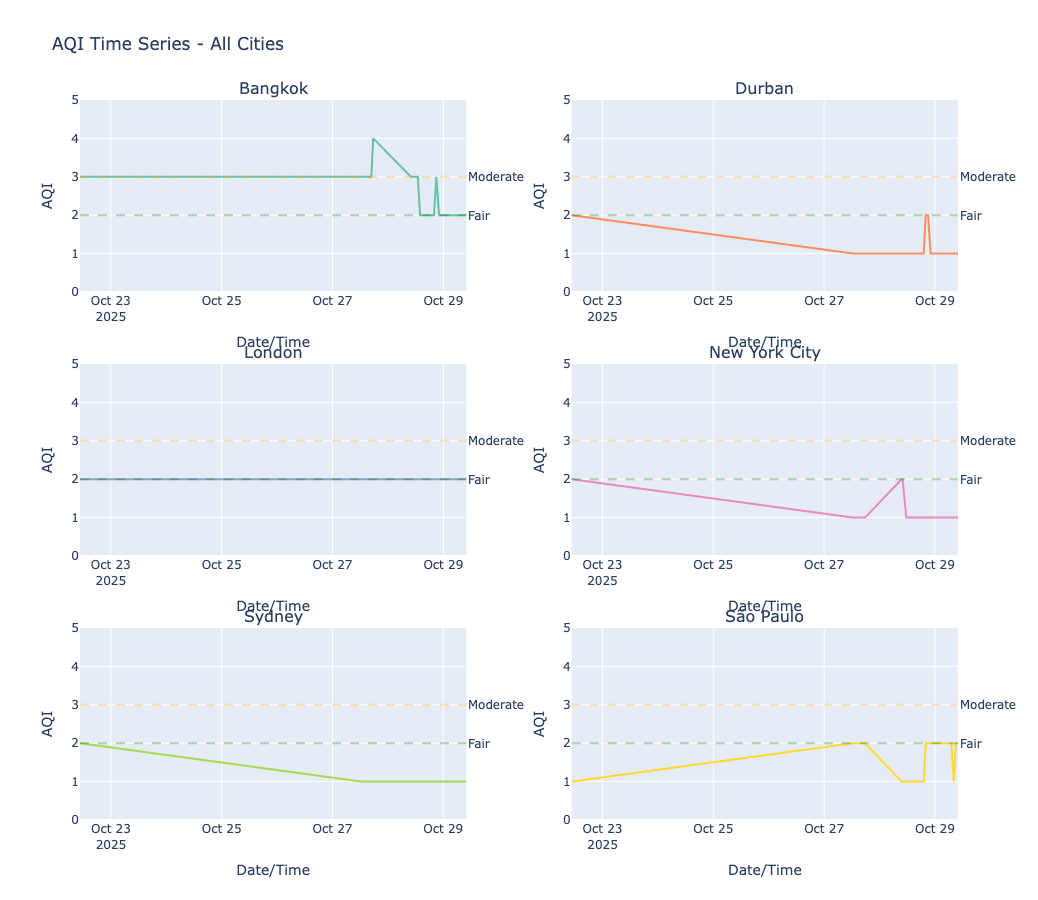

In [4]:
# Create multi-panel time series for all cities
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=tuple(sorted(df['city_name'].unique())),
    vertical_spacing=0.1,
    horizontal_spacing=0.12
)

cities = sorted(df['city_name'].unique())
colors = px.colors.qualitative.Set2

for idx, city in enumerate(cities):
    row = idx // 2 + 1
    col = idx % 2 + 1
    
    city_data = df[df['city_name'] == city].sort_values('timestamp')
    
    fig.add_trace(
        go.Scatter(
            x=city_data['timestamp'],
            y=city_data['aqi'],
            mode='lines',
            name=city,
            line=dict(color=colors[idx % len(colors)], width=2),
            showlegend=False
        ),
        row=row, col=col
    )
    
    # Add reference lines for AQI thresholds
    fig.add_hline(y=2, line_dash="dash", line_color="green", 
                  opacity=0.3, row=row, col=col, 
                  annotation_text="Fair", annotation_position="right")
    fig.add_hline(y=3, line_dash="dash", line_color="orange", 
                  opacity=0.3, row=row, col=col,
                  annotation_text="Moderate", annotation_position="right")

fig.update_xaxes(title_text="Date/Time")
fig.update_yaxes(title_text="AQI", range=[0, 5])
fig.update_layout(
    height=900,
    title_text="AQI Time Series - All Cities",
    showlegend=False
)

fig.show()

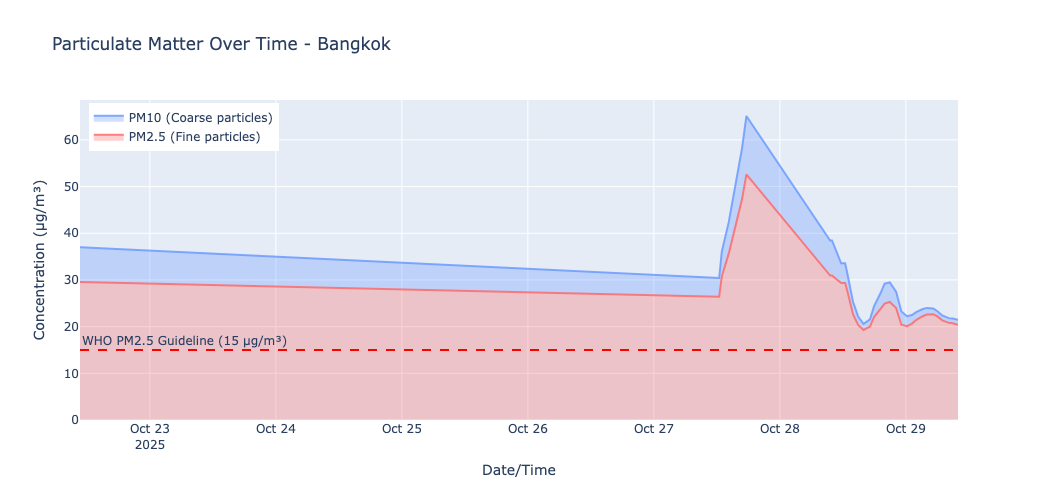


📊 In Bangkok:
   Average PM2.5: 26.31 μg/m³
   Average PM10: 30.15 μg/m³
   PM2.5 exceeds WHO guideline: 36 times (100.0%)


In [5]:
# Show PM2.5 vs PM10 for most polluted city (Bangkok)
city_to_plot = 'Bangkok'
city_data = df[df['city_name'] == city_to_plot].sort_values('timestamp')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=city_data['timestamp'],
    y=city_data['pm2_5'],
    fill='tozeroy',
    name='PM2.5 (Fine particles)',
    line=dict(color='rgba(255, 100, 100, 0.8)', width=2),
    fillcolor='rgba(255, 100, 100, 0.3)'
))

fig.add_trace(go.Scatter(
    x=city_data['timestamp'],
    y=city_data['pm10'],
    fill='tonexty',
    name='PM10 (Coarse particles)',
    line=dict(color='rgba(100, 150, 255, 0.8)', width=2),
    fillcolor='rgba(100, 150, 255, 0.3)'
))

# Add WHO guideline
fig.add_hline(y=15, line_dash="dash", line_color="red", 
              annotation_text="WHO PM2.5 Guideline (15 μg/m³)", 
              annotation_position="top left")

fig.update_layout(
    title=f'Particulate Matter Over Time - {city_to_plot}',
    xaxis_title='Date/Time',
    yaxis_title='Concentration (μg/m³)',
    hovermode='x unified',
    height=500,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

print(f"\n📊 In {city_to_plot}:")
print(f"   Average PM2.5: {city_data['pm2_5'].mean():.2f} μg/m³")
print(f"   Average PM10: {city_data['pm10'].mean():.2f} μg/m³")
print(f"   PM2.5 exceeds WHO guideline: {(city_data['pm2_5'] > 15).sum()} times ({(city_data['pm2_5'] > 15).sum() / len(city_data) * 100:.1f}%)")

## 4. Correlation Analysis 🔍

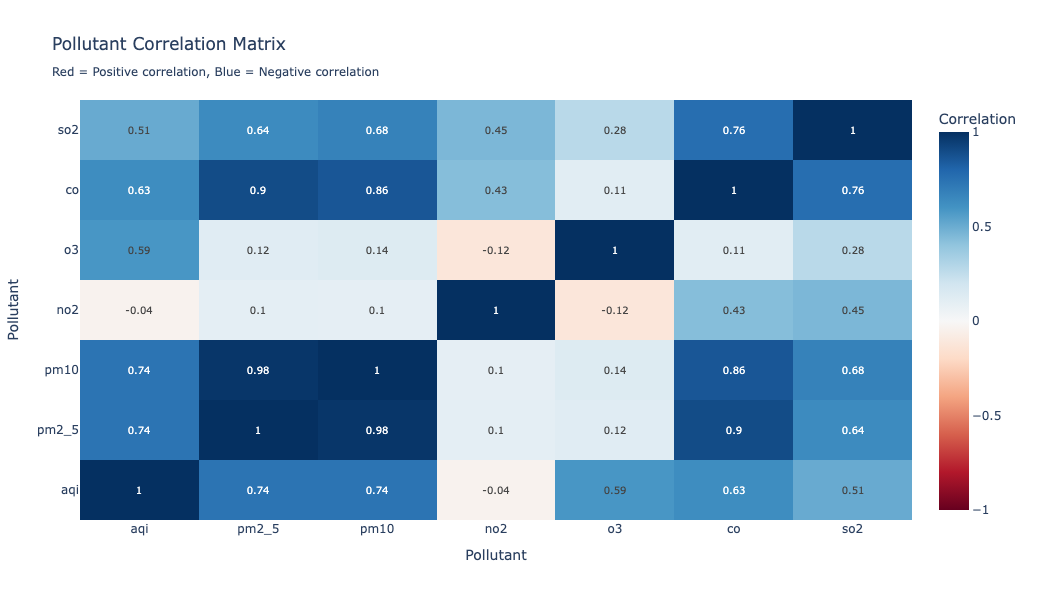


🔍 STRONG CORRELATIONS (|r| > 0.6):
   aqi ↔ pm2_5: r = 0.738 (Strong Positive)
   aqi ↔ pm10: r = 0.737 (Strong Positive)
   aqi ↔ co: r = 0.629 (Strong Positive)
   pm2_5 ↔ pm10: r = 0.980 (Very Strong Positive)
   pm2_5 ↔ co: r = 0.898 (Very Strong Positive)
   pm2_5 ↔ so2: r = 0.636 (Strong Positive)
   pm10 ↔ co: r = 0.860 (Very Strong Positive)
   pm10 ↔ so2: r = 0.677 (Strong Positive)
   co ↔ so2: r = 0.764 (Strong Positive)


In [6]:
# Correlation matrix
pollutants = ['aqi', 'pm2_5', 'pm10', 'no2', 'o3', 'co', 'so2']
corr_matrix = df[pollutants].corr()

# Interactive correlation heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu',
    zmid=0,
    text=corr_matrix.values.round(2),
    texttemplate='%{text}',
    textfont={"size": 10},
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    title='Pollutant Correlation Matrix<br><sub>Red = Positive correlation, Blue = Negative correlation</sub>',
    xaxis_title='Pollutant',
    yaxis_title='Pollutant',
    height=600,
    width=700
)

fig.show()

# Print strong correlations
print("\n🔍 STRONG CORRELATIONS (|r| > 0.6):")
print("=" * 60)
strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.6:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            strength = "Very Strong" if abs(corr_val) > 0.8 else "Strong"
            direction = "Positive" if corr_val > 0 else "Negative"
            print(f"   {var1} ↔ {var2}: r = {corr_val:.3f} ({strength} {direction})")
            strong_corr.append((var1, var2, corr_val))

if not strong_corr:
    print("   No correlations above 0.6 threshold")

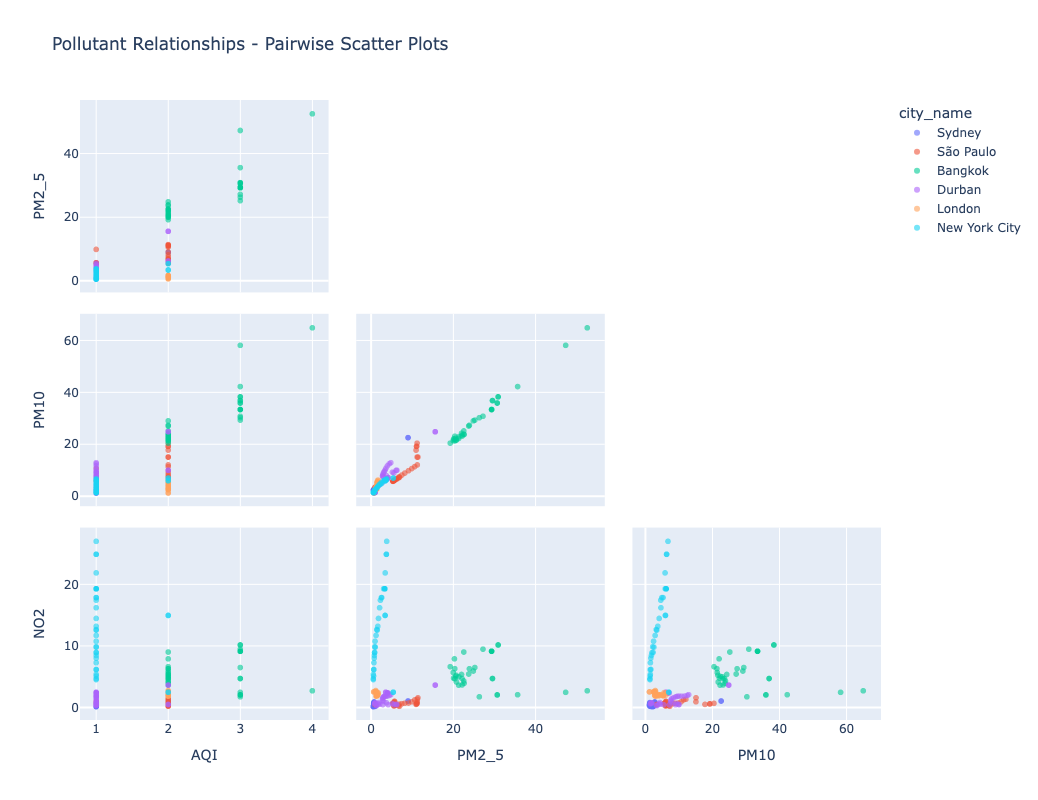


💡 How to read this:
   • Each panel shows relationship between two pollutants
   • Colors represent different cities
   • Look for patterns and clusters


In [7]:
# Scatter matrix for key pollutants
key_pollutants = ['aqi', 'pm2_5', 'pm10', 'no2']

fig = px.scatter_matrix(
    df,
    dimensions=key_pollutants,
    color='city_name',
    title='Pollutant Relationships - Pairwise Scatter Plots',
    labels={col: col.upper() for col in key_pollutants},
    height=800,
    opacity=0.6
)

fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.show()

print("\n💡 How to read this:")
print("   • Each panel shows relationship between two pollutants")
print("   • Colors represent different cities")
print("   • Look for patterns and clusters")

## 5. Interactive Dashboard 📊

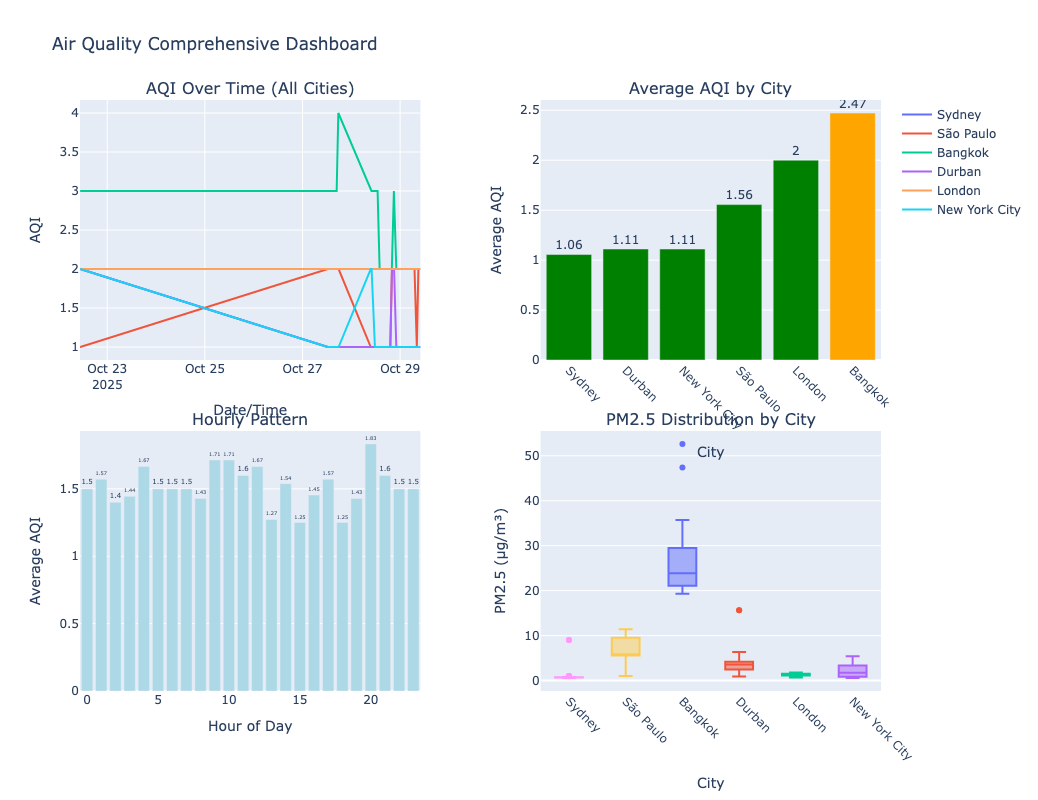


✅ Dashboard saved to: /Users/davideferreri/Documents/GitHub/City-Air-Quality-Index-Predictor-with-Live-Data-Pipeline/notebooks/aqi_dashboard.html
📊 You can open this HTML file in any browser for a standalone dashboard!


In [8]:
# Create comprehensive dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'AQI Over Time (All Cities)',
        'Average AQI by City',
        'Hourly Pattern',
        'PM2.5 Distribution by City'
    ),
    specs=[
        [{"type": "scatter"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "box"}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# 1. Time series (top left)
for city in df['city_name'].unique():
    city_data = df[df['city_name'] == city].sort_values('timestamp')
    fig.add_trace(
        go.Scatter(x=city_data['timestamp'], y=city_data['aqi'],
                   name=city, mode='lines', showlegend=True),
        row=1, col=1
    )

# 2. City averages (top right)
city_avg = df.groupby('city_name')['aqi'].mean().sort_values()
colors_bar = ['green' if x <= 2 else 'orange' if x <= 3 else 'red' for x in city_avg.values]
fig.add_trace(
    go.Bar(x=city_avg.index, y=city_avg.values, marker_color=colors_bar,
           showlegend=False, text=city_avg.values.round(2), textposition='outside'),
    row=1, col=2
)

# 3. Hourly pattern (bottom left)
hourly = df.groupby('hour')['aqi'].mean()
fig.add_trace(
    go.Bar(x=hourly.index, y=hourly.values, marker_color='lightblue',
           showlegend=False, text=hourly.values.round(2), textposition='outside'),
    row=2, col=1
)

# 4. PM2.5 box plot (bottom right)
for city in df['city_name'].unique():
    fig.add_trace(
        go.Box(y=df[df['city_name'] == city]['pm2_5'],
               name=city, showlegend=False),
        row=2, col=2
    )

# Update layout
fig.update_layout(height=800, title_text="Air Quality Comprehensive Dashboard", showlegend=True)
fig.update_xaxes(title_text="Date/Time", row=1, col=1)
fig.update_xaxes(title_text="City", tickangle=45, row=1, col=2)
fig.update_xaxes(title_text="Hour of Day", row=2, col=1)
fig.update_xaxes(title_text="City", tickangle=45, row=2, col=2)

fig.update_yaxes(title_text="AQI", row=1, col=1)
fig.update_yaxes(title_text="Average AQI", row=1, col=2)
fig.update_yaxes(title_text="Average AQI", row=2, col=1)
fig.update_yaxes(title_text="PM2.5 (μg/m³)", row=2, col=2)

fig.show()

# Save dashboard
dashboard_path = project_root / 'notebooks' / 'aqi_dashboard.html'
fig.write_html(str(dashboard_path))
print(f"\n✅ Dashboard saved to: {dashboard_path}")
print("📊 You can open this HTML file in any browser for a standalone dashboard!")

## 6. Pollutant Relationships 🔬

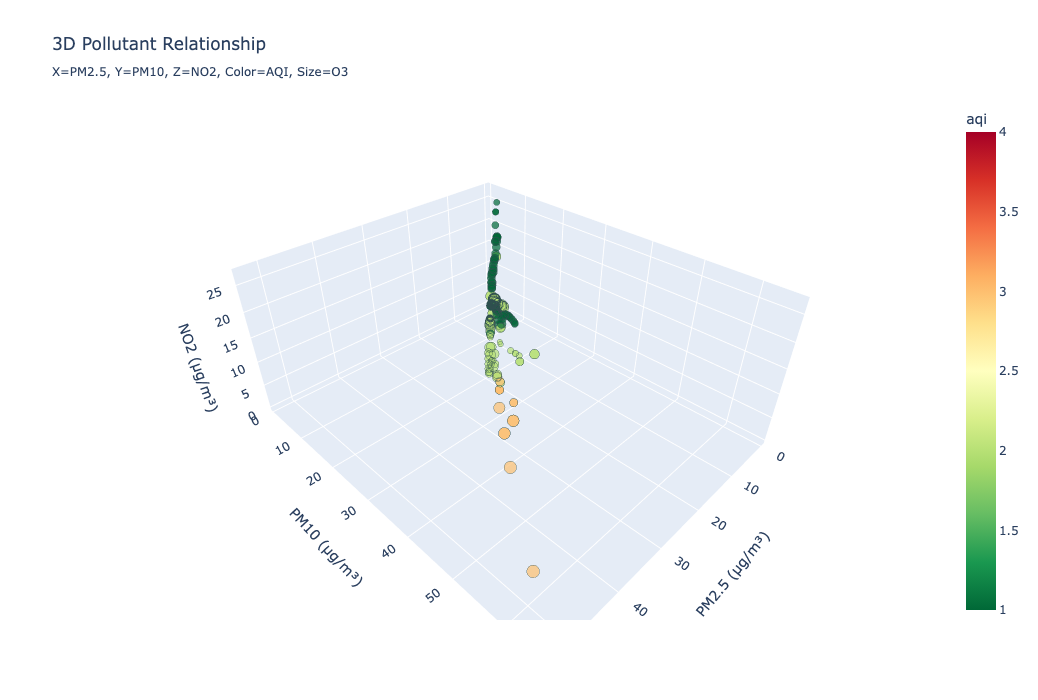


💡 Interactive 3D plot - you can:
   • Click and drag to rotate
   • Scroll to zoom in/out
   • Hover over points for details


In [9]:
# 3D scatter plot showing pollutant relationships
fig = px.scatter_3d(
    df,
    x='pm2_5',
    y='pm10',
    z='no2',
    color='aqi',
    size='o3',
    hover_data=['city_name', 'timestamp'],
    title='3D Pollutant Relationship<br><sub>X=PM2.5, Y=PM10, Z=NO2, Color=AQI, Size=O3</sub>',
    labels={'pm2_5': 'PM2.5 (μg/m³)', 'pm10': 'PM10 (μg/m³)', 'no2': 'NO2 (μg/m³)'},
    color_continuous_scale='RdYlGn_r',
    height=700
)

fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))

fig.show()

print("\n💡 Interactive 3D plot - you can:")
print("   • Click and drag to rotate")
print("   • Scroll to zoom in/out")
print("   • Hover over points for details")

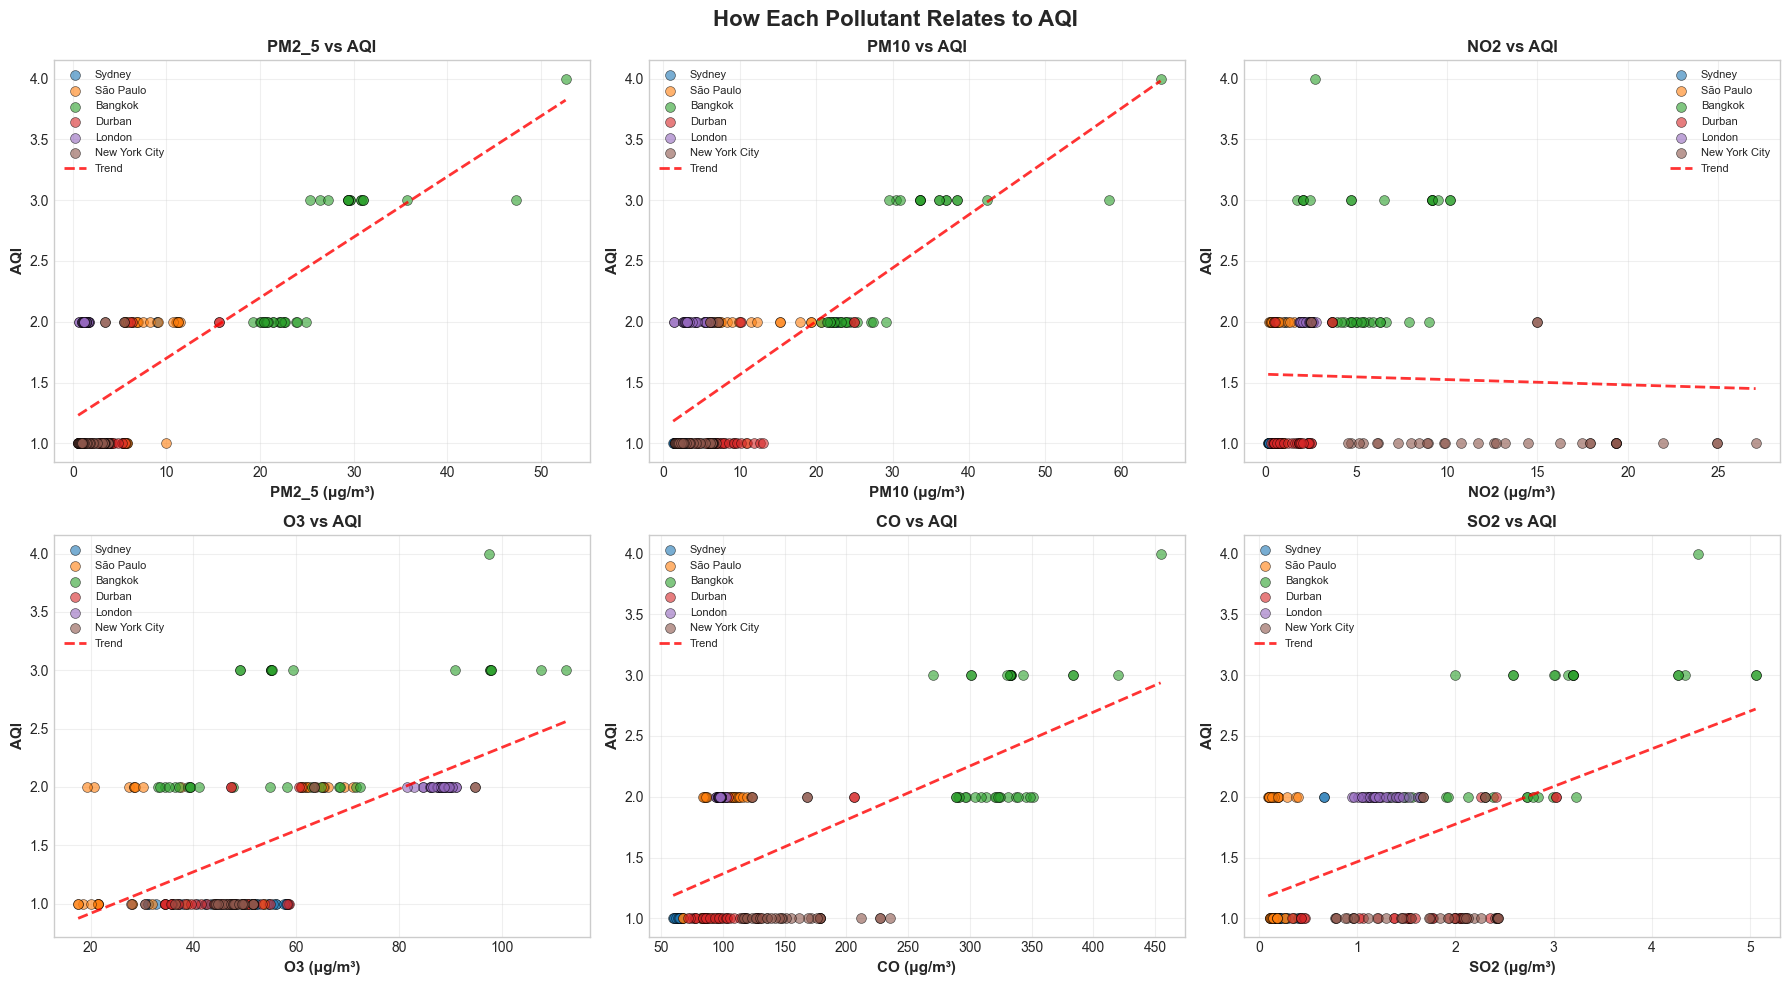


📈 Interpretation:
   • Steeper red line = stronger relationship with AQI
   • Spread of points = variability in the relationship
   • Different colored clusters = different city patterns


In [10]:
# Show how each pollutant relates to AQI
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('How Each Pollutant Relates to AQI', fontsize=16, fontweight='bold')

pollutants_plot = ['pm2_5', 'pm10', 'no2', 'o3', 'co', 'so2']
colors_scatter = plt.cm.Set2(range(6))

for idx, pollutant in enumerate(pollutants_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Scatter plot with color by city
    for city_idx, city in enumerate(df['city_name'].unique()):
        city_data = df[df['city_name'] == city]
        ax.scatter(city_data[pollutant], city_data['aqi'], 
                   label=city, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    if len(df[pollutant].dropna()) > 0:
        z = np.polyfit(df[pollutant].dropna(), df.loc[df[pollutant].notna(), 'aqi'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(df[pollutant].min(), df[pollutant].max(), 100)
        ax.plot(x_trend, p(x_trend), "r--", linewidth=2, label='Trend', alpha=0.8)
    
    ax.set_xlabel(f'{pollutant.upper()} (μg/m³)', fontweight='bold', fontsize=11)
    ax.set_ylabel('AQI', fontweight='bold', fontsize=11)
    ax.set_title(f'{pollutant.upper()} vs AQI', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

print("\n📈 Interpretation:")
print("   • Steeper red line = stronger relationship with AQI")
print("   • Spread of points = variability in the relationship")
print("   • Different colored clusters = different city patterns")

## 7. Key Findings & Export 📋

In [11]:
# Summary of visualizations created
print("=" * 80)
print("VISUALIZATION SUMMARY")
print("=" * 80)

print("\n✅ Created the following visualizations:")
print("   1. 🗺️  Interactive world map (city_aqi_map.html)")
print("   2. 📈 Multi-city time series plots")
print("   3. 🔬 PM2.5 vs PM10 temporal comparison")
print("   4. 🔍 Correlation heatmap")
print("   5. 📊 Pairwise scatter matrix")
print("   6. 📊 Comprehensive 4-panel dashboard (aqi_dashboard.html)")
print("   7. 🌐 3D pollutant relationship plot")
print("   8. 📈 Pollutant-AQI relationship grid")

print("\n📁 Files saved in notebooks/ directory:")
files_created = []
if (project_root / 'notebooks' / 'city_aqi_map.html').exists():
    files_created.append("city_aqi_map.html")
if (project_root / 'notebooks' / 'aqi_dashboard.html').exists():
    files_created.append("aqi_dashboard.html")

for file in files_created:
    print(f"   ✅ {file}")

print("\n💡 Next steps:")
print("   • Review all visualizations above")
print("   • Open HTML files in browser for full interactivity")
print("   • Note patterns for feature engineering")
print("   • Prepare for Notebook 03: Feature Engineering")

print("\n" + "=" * 80)
print("NOTEBOOK 02 COMPLETE! 🎉")
print("=" * 80)

VISUALIZATION SUMMARY

✅ Created the following visualizations:
   1. 🗺️  Interactive world map (city_aqi_map.html)
   2. 📈 Multi-city time series plots
   3. 🔬 PM2.5 vs PM10 temporal comparison
   4. 🔍 Correlation heatmap
   5. 📊 Pairwise scatter matrix
   6. 📊 Comprehensive 4-panel dashboard (aqi_dashboard.html)
   7. 🌐 3D pollutant relationship plot
   8. 📈 Pollutant-AQI relationship grid

📁 Files saved in notebooks/ directory:
   ✅ city_aqi_map.html
   ✅ aqi_dashboard.html

💡 Next steps:
   • Review all visualizations above
   • Open HTML files in browser for full interactivity
   • Note patterns for feature engineering
   • Prepare for Notebook 03: Feature Engineering

NOTEBOOK 02 COMPLETE! 🎉


---
## 🎯 Key Visual Insights

Based on the visualizations above, we can observe:

### **Geographic Patterns**
- Sydney consistently shows the cleanest air (green markers)
- Bangkok shows moderate pollution levels (orange markers)
- Clear geographic clustering of air quality

### **Temporal Patterns**
- Time series show variations throughout the day
- Some cities show more stability than others
- Patterns may indicate rush hour effects

### **Pollutant Relationships**
- Strong correlations between PM2.5 and PM10 (expected)
- AQI driven primarily by particulate matter
- Different cities show different pollutant profiles

### **Next Notebook**
**03_feature_engineering.ipynb** will focus on:
- Creating lag features
- Rolling statistics
- Time-based transformations
- Preparing data for modeling

---
**Notebook completed! 🎨✨**